In [11]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import logging as log
from enum import Enum
from os.path import join, exists, isfile, isdir, abspath, dirname, basename, realpath
from os import makedirs, listdir, pardir, getcwd
from dataclasses import dataclass, field
from typing import Union

import plotly.graph_objects as go

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
def undirected_to_directed(graph: nx.Graph) -> nx.DiGraph:
    """
    Converts an undirected graph to a directed graph
    """
    di_graph = nx.DiGraph()
    di_graph.add_edges_from(graph.edges())
    return di_graph

def get_graph(graph: nx.Graph, graph_type: str) -> Union[nx.Graph, nx.DiGraph]:
    """
    Returns the graph based on the graph type
    """
    if graph_type == str(GRAPH_TYPE.DIRECTED):
        return undirected_to_directed(graph)
    elif graph_type == str(GRAPH_TYPE.BOTH):
        return graph
    else:
        print_error(f"Unknown graph type: {graph_type}")
        return graph

def convert_to_normal(snake_case: str) -> str:
    """
    Converts a snake case string to a normal title string

    Input:  "in_degree_centrality"
    Output: "In Degree Centrality"
    """
    components = snake_case.split('_')
    return " ".join(x.title() for x in components)

def print_log(text: str):
    """
    Prints the log
    """
    print(f"[ log ]: {text}")
    # log.info(f"[ log ]: {text}")

def print_error(text: str):
    """
    Prints the error
    """
    print(f"[ error ]: {text}")
    # log.warn(f"[ error ]: {text}")

In [4]:
def downsample_connected_graph(graph: nx.Graph, largest_cc: set, sample_size: int = 25, verbose: bool = False, plot: bool = False) -> nx.Graph:
    """
    Down-samples the graph to only contain "sample_size" number of nodes
    """
    # pick a random node from the largest connected component
    __node = np.random.choice(list(largest_cc))
    __total_nodes, __graph = 0, nx.Graph()
    
    for i, _ in enumerate(range(1, sample_size)):
        # get the ego graph of the node
        __ego_graph = nx.ego_graph(graph, __node, radius=i)
        __total_nodes = len(__ego_graph)
        if (__total_nodes >= sample_size) and not nx.is_empty(__graph): break
        if verbose: print_log(f"Node: '{__node}' yields '{__total_nodes}' ego-graph nodes after radius '{i}'")
        __graph = __ego_graph
    
    if plot: nx.draw(__graph, with_labels=True)
    return __graph

def make_graph_connected(graph: nx.Graph, sample_size: int = 25, sorted_cc: list = list(), verbose: bool = False, plot: bool = False) -> nx.Graph:
    """
    Connect the graph by adding more edges between the nodes of connected components
    """
    if sample_size <= 0: raise ValueError(f"Invalid sample size: {sample_size}")
    if len(sorted_cc) <= 1: raise ValueError(f"Invalid connected component list")
    
    largest_cc = sorted_cc[0]
    __first_node = list(largest_cc)[0]

    __graph = nx.subgraph(graph, largest_cc).copy()

    for i, cc in enumerate(sorted_cc[1:]):
        # return if adding another connected component will make the graph bigger than sample size
        if (len(__graph) + len(cc)) > sample_size:
            if verbose: print_log(f"Graph size: {len(__graph)} + CC({i + 1}): {len(cc)} > Sample Size: {sample_size}")
            break
        # add new edge to make the graph connected
        if verbose: print_log(f"Adding edge between '{__first_node}' and '{list(cc)[0]}'")
        __graph.add_edge(__first_node, list(cc)[0])

        # add the new connected component to the graph
        if verbose: print_log(f"Adding {len(cc)} nodes from CC({i + 1}) to the graph")
        __graph.add_edges_from(nx.subgraph(graph, cc).edges())

    if plot:
        fig, axes = plt.subplots(nrows=1, ncols=2)
        axes[0].set_title("Original Graph")
        nx.draw(graph, with_labels=True, ax=axes[0])
        axes[1].set_title("Final Graph")
        nx.draw(__graph, with_labels=True, ax=axes[1])
    return __graph

def sample_graph(graph: Union[nx.Graph, nx.DiGraph], sample_size: int = 25, verbose: bool = False, plot: bool = False) -> Union[nx.Graph, nx.DiGraph]:
    """
    Returns a sample graph of the given 'sample_size'
    """
    if sample_size <= 0: raise ValueError(f"Invalid sample size: {sample_size}")

    is_directed = nx.is_directed(graph) and isinstance(graph, nx.DiGraph)
    if is_directed: graph = graph.to_undirected()

    sorted_cc = sorted(nx.connected_components(graph), key=len, reverse=True)
    largest_cc = sorted_cc[0]

    __graph = nx.Graph()

    if sample_size > len(largest_cc):
        if verbose: print_error(f"Sample size {sample_size} is greater than the largest connected component size {len(largest_cc)}")
        if nx.is_connected(graph):
            if verbose: print_log(f"Graph is connected")
            __graph = graph.copy()
        else:
            # make graph bigger by connecting the connected components
            if verbose: print_log(f"Making graph connected")
            __graph = make_graph_connected(graph=graph, sample_size=sample_size, sorted_cc=sorted_cc, verbose=verbose, plot=plot)
    else:
        # make graph shorter by keeping 'sample_size' elements only and connecting them
        if verbose: print_log(f"Downsampling a larger graph")
        __graph = downsample_connected_graph(graph=graph, largest_cc=largest_cc, sample_size=sample_size, verbose=verbose, plot=plot)
    
    return undirected_to_directed(__graph) if is_directed else __graph

[ log ]: Downsampling a larger graph
[ log ]: Node: 'F26A3.2' yields '1' ego-graph nodes after radius '0'
[ log ]: Node: 'F26A3.2' yields '2' ego-graph nodes after radius '1'
[ log ]: Node: 'F26A3.2' yields '6' ego-graph nodes after radius '2'
[ log ]: Node: 'F26A3.2' yields '19' ego-graph nodes after radius '3'
[ log ]: Node: 'F26A3.2' yields '46' ego-graph nodes after radius '4'
Graph with 46 nodes and 45 edges


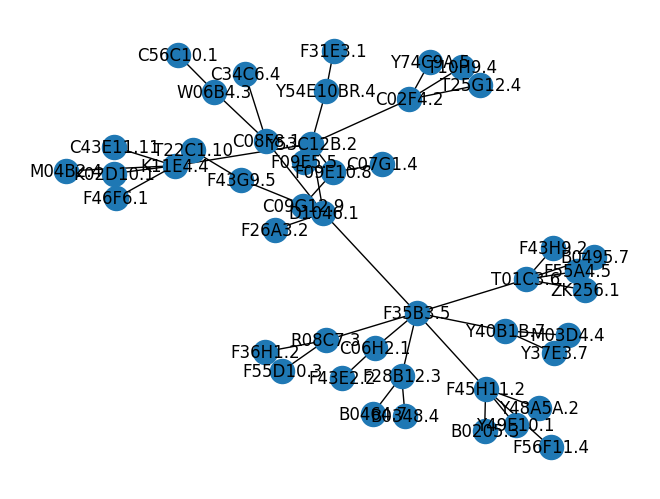

In [5]:
#import the data
#data source: https://www.inetbio.org/wormnet/downloadnetwork.php

parent_dir = abspath(join(join(getcwd(), pardir), pardir))
data_dir = join(parent_dir, 'data')
data_file = join(data_dir, 'DM-HT.txt')
# data_file = join(data_dir, 'DM-HT_small.txt')

sample_size = 50

graph = nx.read_edgelist(data_file, nodetype=str, data=(("weight", float),))
graph = sample_graph(graph=graph, sample_size=sample_size, verbose=True, plot=True)
di_graph = undirected_to_directed(graph)

print(f"{graph}")

In [20]:
[x for x in graph.edges()][:3]

[('F46F6.1', 'K11E4.4'), ('F31E3.1', 'Y54E10BR.4'), ('F55A4.5', 'T01C3.6')]

In [22]:
x, y = [x for x in graph.edges()][0]

x0, y0 = pos[x]
x1, y1 = pos[y]

x0, y0, x1, y1

(-0.4986879681898865,
 -0.9692458866527737,
 -0.35609585247318715,
 -0.7618333706773945)

In [23]:
edge_x = []
edge_y = []
for edge in graph.edges():
    x, y = edge
    x0, y0 = pos[x]
    x1, y1 = pos[y]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_y.append(y0)
    edge_y.append(y1)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
    )

In [12]:
node_x = []
node_y = []
for node in graph.nodes():
    x, y =pos[node][0],pos[node][1]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

In [13]:
node_degree_centrality = []
node_text = []

for node in graph_fly.nodes():
    node_degree_centrality.append(degree_centrality_graph_fly[node])
    node_text.append('# of degrees: '+ str(degree_centrality_graph_fly[node]))
node_trace.marker.color = node_degree_centrality
node_trace.text = node_text

In [14]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph made with Python',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

In [15]:
nx.communicability_betweenness_centrality(graph_fly_sampleDraw_undirected)

/opt/homebrew/Caskroom/mambaforge/base/envs/mgma/lib/python3.9/site-packages/networkx/algorithms/centrality/subgraph_alg.py:275: RuntimeWarning:

invalid value encountered in divide



{'4R79.2': nan,
 'F33A8.4': nan,
 'K08E4.1': nan,
 'Y37E3.9': nan,
 'Y59A8B.1': nan,
 'AC3.2': nan,
 'C55A6.10': nan,
 'AC3.7': nan,
 'C36B7.6': nan,
 'F55F8.5': nan,
 'R166.2': nan,
 'AC3.8': nan,
 'AC7.2': nan,
 'F59F5.6': nan,
 'B0024.11': nan,
 'K01G5.2': nan,
 'K08H2.6': nan,
 'Y74C9A.3': nan,
 'B0024.13': nan,
 'M142.1': nan,
 'B0024.14': nan,
 'D2021.2': nan,
 'T16H12.5': nan,
 'B0024.9': nan,
 'T27A10.3': nan,
 'T27E9.3': nan}

In [16]:
nx.in_degree_centrality(graph_fly_sampleDraw)

{'4R79.2': 0.0,
 'F33A8.4': 0.04,
 'K08E4.1': 0.04,
 'Y37E3.9': 0.04,
 'Y59A8B.1': 0.04,
 'AC3.2': 0.0,
 'C55A6.10': 0.04,
 'AC3.7': 0.0,
 'C36B7.6': 0.08,
 'F55F8.5': 0.08,
 'R166.2': 0.08,
 'AC3.8': 0.0,
 'AC7.2': 0.0,
 'F59F5.6': 0.04,
 'B0024.11': 0.0,
 'K01G5.2': 0.04,
 'K08H2.6': 0.04,
 'Y74C9A.3': 0.04,
 'B0024.13': 0.0,
 'M142.1': 0.04,
 'B0024.14': 0.0,
 'D2021.2': 0.04,
 'T16H12.5': 0.04,
 'B0024.9': 0.0,
 'T27A10.3': 0.04,
 'T27E9.3': 0.04}

In [17]:
nx.betweenness_centrality(graph_fly_sampleDraw)

{'4R79.2': 0.0,
 'F33A8.4': 0.0,
 'K08E4.1': 0.0,
 'Y37E3.9': 0.0,
 'Y59A8B.1': 0.0,
 'AC3.2': 0.0,
 'C55A6.10': 0.0,
 'AC3.7': 0.0,
 'C36B7.6': 0.0,
 'F55F8.5': 0.0,
 'R166.2': 0.0,
 'AC3.8': 0.0,
 'AC7.2': 0.0,
 'F59F5.6': 0.0,
 'B0024.11': 0.0,
 'K01G5.2': 0.0,
 'K08H2.6': 0.0,
 'Y74C9A.3': 0.0,
 'B0024.13': 0.0,
 'M142.1': 0.0,
 'B0024.14': 0.0,
 'D2021.2': 0.0,
 'T16H12.5': 0.0,
 'B0024.9': 0.0,
 'T27A10.3': 0.0,
 'T27E9.3': 0.0}

In [18]:
#nx.current_flow_betweenness_centrality(graph_fly_sampleDraw)
#for undirected graphs only

In [19]:
nx.closeness_centrality(graph_fly_sampleDraw)

{'4R79.2': 0.0,
 'F33A8.4': 0.04,
 'K08E4.1': 0.04,
 'Y37E3.9': 0.04,
 'Y59A8B.1': 0.04,
 'AC3.2': 0.0,
 'C55A6.10': 0.04,
 'AC3.7': 0.0,
 'C36B7.6': 0.08,
 'F55F8.5': 0.08,
 'R166.2': 0.08,
 'AC3.8': 0.0,
 'AC7.2': 0.0,
 'F59F5.6': 0.04,
 'B0024.11': 0.0,
 'K01G5.2': 0.04,
 'K08H2.6': 0.04,
 'Y74C9A.3': 0.04,
 'B0024.13': 0.0,
 'M142.1': 0.04,
 'B0024.14': 0.0,
 'D2021.2': 0.04,
 'T16H12.5': 0.04,
 'B0024.9': 0.0,
 'T27A10.3': 0.04,
 'T27E9.3': 0.04}

In [20]:
# nx.eigenvector_centrality(graph_fly_sampleDraw)
# for connected graphs only

In [21]:
#nx.current_flow_closeness_centrality(graph_fly_sampleDraw)
#for undirected graphs only

In [22]:
#nx.communicability(graph_fly_sampleDraw)
#for undirected graphs only

In [23]:
nx.load_centrality(graph_fly_sampleDraw)

{'4R79.2': 0.0,
 'F33A8.4': 0.0,
 'K08E4.1': 0.0,
 'Y37E3.9': 0.0,
 'Y59A8B.1': 0.0,
 'AC3.2': 0.0,
 'C55A6.10': 0.0,
 'AC3.7': 0.0,
 'C36B7.6': 0.0,
 'F55F8.5': 0.0,
 'R166.2': 0.0,
 'AC3.8': 0.0,
 'AC7.2': 0.0,
 'F59F5.6': 0.0,
 'B0024.11': 0.0,
 'K01G5.2': 0.0,
 'K08H2.6': 0.0,
 'Y74C9A.3': 0.0,
 'B0024.13': 0.0,
 'M142.1': 0.0,
 'B0024.14': 0.0,
 'D2021.2': 0.0,
 'T16H12.5': 0.0,
 'B0024.9': 0.0,
 'T27A10.3': 0.0,
 'T27E9.3': 0.0}